# Analysing historical discharge data for Loire basin at Blois station

This notebook is used to analyse historical discharge data to analyse periods of drought. An algorithm is used which calculates the amount of droughts and severity of the drought.

### 1. Importing general python modules

In [200]:
# general python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd

# niceties
from rich import print

### 2. Loading data

In [201]:
# load data for Blois catchment
basin_name = "FR003882"
q_data = pd.read_csv("FR003882_streamflow_m3s.csv", index_col='date', parse_dates=True)
#q_data = q_data['1990-01-01':'2019-12-31']

### 3. Plot discharge January vs. August

In [202]:
# get the monthly mean values
Q_mean_month = q_data.groupby(pd.PeriodIndex(q_data.index, freq="M")).mean()

# get the values for January and August
Q_jan = pd.Series(Q_mean_month[basin_name][Q_mean_month.index.month == 1], name='January')
Q_aug = pd.Series(Q_mean_month[basin_name][Q_mean_month.index.month == 8], name='August')

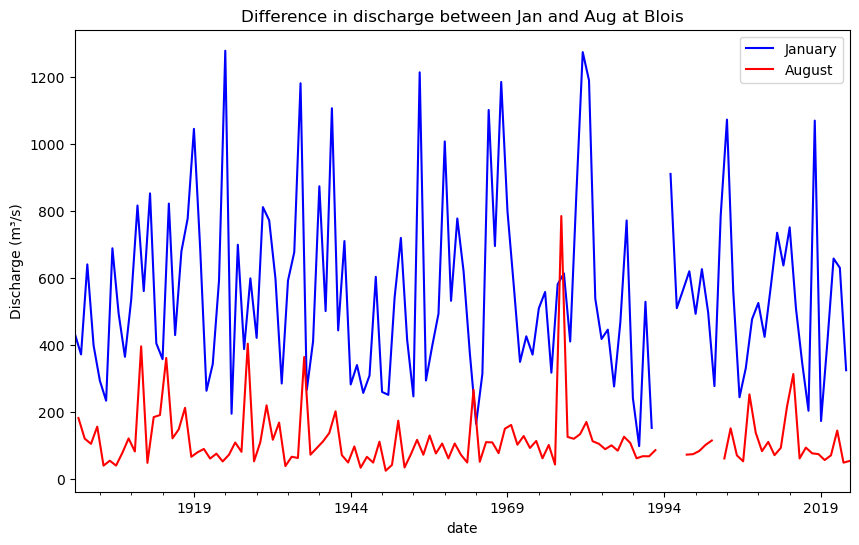

In [203]:
# plot the results
plt.figure(figsize=(10, 6))
Q_jan.plot(label="January", color='blue')
Q_aug.plot(label="August", color='red')
plt.title('Difference in discharge between Jan and Aug at Blois')
plt.ylabel('Discharge (m³/s)')
plt.legend()
plt.show()

### 4. Create a function which detects droughts

In [204]:
def drought_analyser(df, basin_name: str, q_crit: float):
    droughts = []
    drought_counter = 0
    i = 0
    
    while i < len(df):
        if df[basin_name].iloc[i] <= q_crit:
            drought_counter += 1
            days_counter = 0
            deficit_list = []
            accum_deficit = 0
            max_cumulative_deficit = 0
            start_date = df.index[i]
            
            while i < len(df):
                deficit = df[basin_name].iloc[i] - q_crit
                deficit_list.append(deficit)
                accum_deficit += deficit
                max_cumulative_deficit = min(max_cumulative_deficit, accum_deficit)  # Track the most negative deficit
                days_counter += 1
                i += 1
                
                if accum_deficit > 0:  # Stop when the system is replenished
                    break
            
            droughts.append({
                "Drought Number": drought_counter,
                "Start Date": start_date,
                "Duration (days)": days_counter,
                "Max Cumulative Deficit": max_cumulative_deficit
            })
        else:
            i += 1
    
    return pd.DataFrame(droughts)

### 5. Plot the data and fit a line

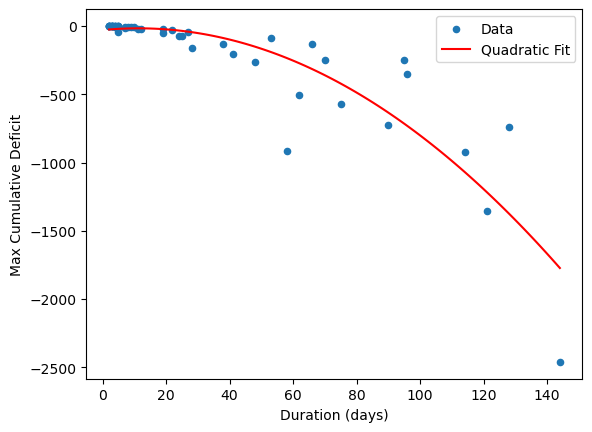

In [205]:
drought_df = drought_analyser(q_data, basin_name, 50)
ax = drought_df.plot(x="Duration (days)", y="Max Cumulative Deficit", kind="scatter", label="Data")

# Extract x and y values
x = drought_df["Duration (days)"]
y = drought_df["Max Cumulative Deficit"]

# Fit a quadratic function (parabola)
coeffs = np.polyfit(x, y, 2)  # 2nd-degree polynomial (quadratic)
poly_func = np.poly1d(coeffs)  # Convert to polynomial function

# Generate smooth x values for the curve
x_smooth = np.linspace(x.min(), x.max(), 100)
y_smooth = poly_func(x_smooth)

# Plot the fitted curve
plt.plot(x_smooth, y_smooth, color="red", label="Quadratic Fit")

# Show legend
plt.legend()
plt.show()